In [1]:
import numpy as np
from netCDF4 import Dataset
import xarray as xr

from scipy import sparse
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sp_linalg
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import random
import datetime
import cartopy.feature as cfeat


## Functions and kernels


In [2]:
def extract_data(directory, file):
    R = Dataset(directory+file, 'r')
    
    lons = np.asarray(R['lon'])
    lats = np.asarray(R['lat'])
    lons[lons>180]-=360
    lons[lons<-180]+=360
    
    times = np.asarray(R['time'])
    traj = np.asarray(R['trajectory'])
    
    
    return lons, lats, times,traj


def remove_nans(lons,lats, n_particles):

    print('Removing deleted particles...')

    if np.any(np.ma.getmask(lons)):
        inds = np.bitwise_or.reduce(np.ma.getmask(lons), 1)
        lons   = lons[~inds]
        lats   = lats[~inds]
        print('Number of removed particles: ', n_particles - len(lons))
        n_particles  = len(lons)

    elif np.any(np.isnan(lons)):
        inds = np.bitwise_or.reduce(np.isnan(lons), 1)
        lons = lons[~inds]
        lats = lats[~inds]    
        print('Number of removed particles: ', n_particles - len(lons))
        n_particles  = len(lons)

    else:
        print('Data does not contain any masked elements')

    print('---------------------')  
    nans_removed = True
    return lons, lats, n_particles
    
def set_discretizing_values(d_deg, minlon = 27, maxlon =42., minlat = 40., maxlat=48.):
    """
    Set cell size for matrix computation
    """
    d_deg  = d_deg
    n_lons  = int(((maxlon+1) - (minlon+1))/d_deg)
    n_lats  = int(((maxlat+1) - (minlat+1))/d_deg)
    n_total   = n_lons * n_lats        
    discrete = True
    
    return n_lons,n_lats,n_total

class ParticleData(object):
    def __init__(self):
        self.id = []
        
def load_particles_file(fname, varnames):
    T = ParticleData()
    pfile = xr.open_dataset(str(fname), decode_cf=True)
    T.id = pfile.variables['trajectory'][:]

    for v in varnames:
        setattr(T, v,  np.ma.filled(pfile.variables[v][:], np.nan))
    pfile.close()
    
    return T


def savefig(filename):
    
    plt.savefig(ddir+filename+".png") # save plot as png-file 
    return print('File successful saved as:', filename)

# Load Data


In [53]:
ddir = r'C:\Users\Administrateur\Documents\CP_18-20\Thesis\Parcels' 
outdir = r'C:\Users\Administrateur\Documents\CP_18-20\Thesis\Parcels' 

files = r'\RUN3_120d.nc'
#files = r'\Rivers\RUN_RIVERS4_weighted_365d.nc'

lon, lat,time,tra = extract_data(ddir, files)
lon = np.array(lon)
lat = np.array(lat)

D = {}
D = load_particles_file(ddir+files, ['time'])
    
n_particles = len(lon)

plottimes = np.arange(np.min(D.time), np.max(D.time), dtype='datetime64[1D]')

print('Total number of particles :', n_particles)

C:\Anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
C:\Anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


Total number of particles : 38260


# Indexing


In [54]:
d_deg = 0.2
minlon = 27.
maxlon =42
minlat = 40.
maxlat=48.

m_lon, m_lat, m_tot = set_discretizing_values(d_deg, minlon, maxlon, minlat,maxlat) 

index_lo, index_la,Longitude, Latitude = [[] for i in range(4)]

##Preparing data : eliminating NaNs
Longitude, Latitude, NPart = remove_nans(lon,lat,n_particles)

## Real values indexing
"""
Find index of Lon/Lat values on the entropy grid (i.e., minlon, maxlon, minlat, maxlat with dx=dy=d_deg)
"""

indexLat1_i = [abs((Latitude[i][0]-minlat)/d_deg)  for i in range(len(Latitude))]
indexLat_i = [int(indexLat1_i[i]) for i in range(len(indexLat1_i))]

indexLon1_i = [abs((Longitude[i][0]-minlon)/d_deg) for i in range(len(Longitude))]
indexLon_i = [int(indexLon1_i[i]) for i in range(len(indexLon1_i))]

indexLat1_f = [abs((Latitude[i][-1]-minlat)/d_deg)  for i in range(len(Latitude))]
indexLat_f = [int(indexLat1_f[i]) for i in range(len(indexLat1_f))]

indexLon1_f = [abs((Longitude[i][-1]-minlon)/d_deg) for i in range(len(Longitude))]
indexLon_f = [int(indexLon1_f[i]) for i in range(len(indexLon1_f))]

assert (len(indexLat_f) == len(indexLon_f))
assert (max(indexLon_f) <= m_lon)
assert(max(indexLat_f) <= m_lat)

## Ravel indexing 
"""
Find the position of Lat/Lon values as if the entropy grid was an array
"""

mI = ([indexLat_i],[indexLon_i])

mF = ([indexLat_f],[indexLon_f])


RI = np.ravel_multi_index(mI,(m_lat,m_lon))
RI = list(RI[0])
RF = np.ravel_multi_index(mF,(m_lat,m_lon))
RF = list(RF[0])

Removing deleted particles...
Number of removed particles:  2160
---------------------


David's code (adapted)

In [55]:
#Pairing the initial/final index for each traj
R_pairs = [(RI[i], RF[i]) for i in range(len(RF))]


#count the tuple occurences
import collections 
Output = collections.defaultdict(float)
for elem in R_pairs:
    Output[elem] += 1.

coords = np.array(list(Output.keys()))

#for the sparse coo matrix
rows = coords[:,0]                       #initial position
columns = coords[:,1]                    #final position
vals = np.array(list(Output.values()))   #probability/density/occurence

#Count each nb of time each indices appear
initial_indices, initial_counts = np.unique(RI, return_counts=True)  

#normalize the values
for i in range(len(initial_indices)):
    vals[rows == initial_indices[i]] /= initial_counts[i]
    
A = sparse.coo_matrix((vals, (rows, columns)), shape=(m_tot, m_tot))

#check if non-zero rows add up to 1
print('Check normalization')
s = sparse.coo_matrix.sum(A, axis=1)
s = s[s!=0]
assert(np.all(np.round(s,1) == 1))

sparse.save_npz(ddir+'\Entropy_Matrix', A)


Check normalization


# Entropy calcuations

In [56]:
Lons_edges=np.linspace(27,42,int(15/d_deg))      
Lats_edges=np.linspace(40,48,int(8/d_deg))
Lons_centered=np.array([(Lons_edges[i]+Lons_edges[i+1])/2. for i in range(len(Lons_edges)-1)])
Lats_centered=np.array([(Lats_edges[i]+Lats_edges[i+1])/2. for i in range(len(Lats_edges)-1)])

S_loc = np.zeros((len(Lats_edges)*len(Lons_edges)))#final entropy field

#load data
A = sparse.load_npz(ddir+ '\Entropy_Matrix' + '.npz')
row = A.row  #initial
col = A.col  #final
val = A.data #               

colsum = np.array(sparse.coo_matrix.sum(A, axis=0))[0]
#print(colsum)


"""
S_k(t) = -sum(P_{i|k} * ln(P_{i|k}(t)))

P_{i|k} (t) = rho_{i|k}(t)/sum(rho_{i|k}(t)

with: i = index and k grid-cell   
"""

M = len(np.unique(row)) #number of labels
S_max = np.log(M)

for c in np.unique(col):
    val[col==c] /= colsum[c]
for c in np.unique(col):
    s = 0.
    for p in val[col==c]:
        if p!=0:
            s-=p * np.log(p)

    S_loc[c]= s/S_max    
    
        
S_loc2=S_loc.reshape((len(Lats_edges),len(Lons_edges)))
S_loc3=np.roll(S_loc2,int(14.8/d_deg), axis = 1)

# Plot

File successful saved as: \Entropy4month


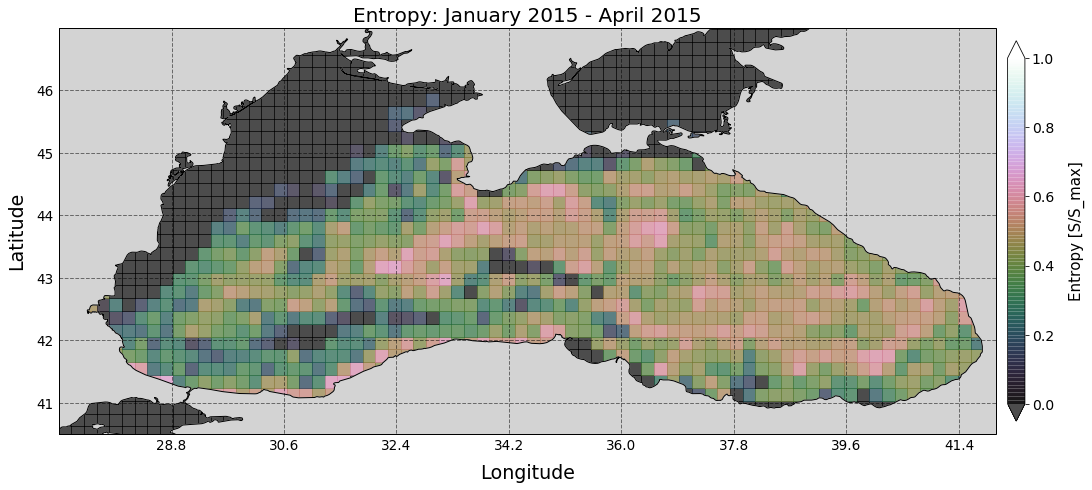

In [57]:
import cartopy.crs as ccrs

proj = ccrs.PlateCarree()
fig = plt.figure (figsize = (20, 20))  
m1 = fig.add_subplot(111, projection = proj) 

extent=[27, 42, 40.5, 47]
m1.set_extent((extent), crs = ccrs.PlateCarree())

gl = m1.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                  linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlabels_bottom = True
gl.ylabel_style = {'size' : 13.5}
gl.xlabel_style = {'size': 13.5}



lon_bins_2d,lat_bins_2d = np.meshgrid(Lons_edges,Lats_edges)
xs, ys = lon_bins_2d, lat_bins_2d



#assert (np.max(S_loc)<=1)

p= plt.pcolormesh(xs,ys,S_loc3, cmap = 'cubehelix',vmin=0, vmax=1,alpha = 0.7, rasterized=True, 
               transform = ccrs.PlateCarree())
plt.title('Entropy: January 2015 - April 2015', size=20)

cbar=fig.colorbar(p, shrink = 0.35,extend = 'both',pad = 0.01)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Entropy [S/S_max]',size=15, labelpad = 15)

land_10m = cfeat.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face',facecolor='lightgrey')

m1.add_feature(land_10m) #facecolor = 'grey')
m1.coastlines('10m')

m1.text(-0.035, 0.5, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=m1.transAxes, fontsize = 19)
m1.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=m1.transAxes, fontsize = 19)

ddir = r'C:\Users\Administrateur\Documents\CP_18-20\Thesis\Figure' 
savefig(r'\Entropy4month')

In [129]:
np.max(S_loc3)

0.8267829144389196